In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('index.csv')
data.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


Define two sets of features as per Laura's summary:
- legal only contains those which are clearly ok to use
- maybe contains also the legally ambiguous features

In [3]:
legal = data.columns[ [1, 3, 5, 6, 8, 10, 12, 14, 16 ] ]
maybe = data.columns[ [1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 14, 15, 16, 17 ] ]

In [4]:
print(data[(data['Foreign Worker']==2) & (data['Creditability']==0)])

     Creditability  Account Balance  Duration of Credit (month)  \
934              0                1                          16   
935              0                1                          20   
976              0                2                          48   
986              0                1                          14   

     Payment Status of Previous Credit  Purpose  Credit Amount  \
934                                  4        0           2625   
935                                  4        0           2235   
976                                  0       10          18424   
986                                  2        0           8978   

     Value Savings/Stocks  Length of current employment  Instalment per cent  \
934                     1                             5                    2   
935                     1                             3                    4   
976                     1                             3                    1   
986          

In [5]:
data.Creditability.value_counts()

1    700
0    300
Name: Creditability, dtype: int64

In [6]:
data['Gender'] = [((data['Sex & Marital Status']==1) | (data['Sex & Marital Status']==3) | (data['Sex & Marital Status']==4))][0]

In [7]:
male = data[(data['Sex & Marital Status']==1) | (data['Sex & Marital Status']==3) | (data['Sex & Marital Status']==4)]
female = data[(data['Sex & Marital Status']==2) | (data['Sex & Marital Status']==5)]

A quick and simple discrimination measure: males are slightly more often assigned good creditability in the data.

In [8]:
print('Ratio of males (n = %d) with good credit risk: %.2f' % (male.shape[0], np.sum(male.Creditability==1) / male.shape[0]))
print('Ratio of females (n = %d) with good credit risk: %.2f' % (female.shape[0], np.sum(female.Creditability==1) / female.shape[0]))

Ratio of males (n = 690) with good credit risk: 0.72
Ratio of females (n = 310) with good credit risk: 0.65


In [9]:
fw = data[(data['Foreign Worker']==1)]
nfw=data[(data['Foreign Worker']==2)]

print('Ratio of foreign workers (n = %d) with good credit risk: %.2f' % (fw.shape[0], np.sum(fw.Creditability==1) / fw.shape[0]))
print('Ratio of non-foreign (n = %d) with good credit risk: %.2f' % (nfw.shape[0], np.sum(nfw.Creditability==1) / nfw.shape[0]))

from scipy import stats
stats.ttest_ind(fw.Creditability, nfw.Creditability, equal_var=False)

Ratio of foreign workers (n = 963) with good credit risk: 0.69
Ratio of non-foreign (n = 37) with good credit risk: 0.89


Ttest_indResult(statistic=-3.7004702925306003, pvalue=0.00061753543257818389)

Discrimination measuring function, returns all, explainable and unexplainable discrimination

In [10]:
def discrimination(data, target, sens, expl, max_corr=.1):
    # target
    # sens: sensitive attribute
    # expl: explanatory attribute(s), str or list
    group_priv = data[data[sens]==2]
    group_prot = data[data[sens]==1]
    n_priv = group_priv.shape[0]
    n_prot = group_prot.shape[0]
    
    D_all = np.sum(group_priv[target]==1)/n_priv - np.sum(group_prot[target] == 1)/n_prot
    print('Total discrimination: %.2f' % D_all)
    
    # multiple explanatory attributes
    if isinstance(expl, list):
        high_corr = list(data.columns[np.abs(data.corr()[sens].sort_values()) > max_corr])
        for e in expl: 
            if e in high_corr: 
                print(e, 'is highly correlated with', sens)
        expl = [e for e in expl if e not in high_corr]
        data_expl = pd.Series(KMeans(n_clusters=4).fit(data[expl]).labels_)
    else:
        data_expl = data[expl]
    
    data_expl_priv = data_expl[data[sens]==2]
    data_expl_prot = data_expl[data[sens]==1]
        
    expl_values = data_expl.unique()
    D_expl = 0 
    
    for e_i in expl_values:
        P_star = (np.sum((group_priv[target]==1) & (data_expl_priv == e_i))/n_priv + 
                  np.sum((group_prot[target]==1) & (data_expl_prot == e_i))/n_prot)/2
        D_expl += (np.sum(data_expl_priv == e_i)/n_priv - np.sum(data_expl_prot == e_i)/n_prot) * P_star
        
    print('Discrimination explainable by %s: %.2f' % (', '.join(expl), D_expl))
    
    D_illegal = D_all - D_expl
    print('Unexplainable discrimination: %.2f' % D_illegal)
    
    return (D_all, D_expl, D_illegal)
    

### Measure discrimination in data

In [14]:
discrimination(data, 'Creditability', 'Foreign Worker', 'Concurrent Credits')

Total discrimination: 0.20
Discrimination explainable by C, o, n, c, u, r, r, e, n, t,  , C, r, e, d, i, t, s: 0.02
Unexplainable discrimination: 0.18


(0.19926468524599361, 0.016012631400575909, 0.18325205384541771)

In [11]:
discrimination(data, 'Creditability', 'Foreign Worker', list(legal))

Total discrimination: 0.20
Account Balance is highly correlated with Foreign Worker
Discrimination explainable by Payment Status of Previous Credit, Credit Amount, Value Savings/Stocks, Instalment per cent, Guarantors, Most valuable available asset, Concurrent Credits, No of Credits at this Bank: 0.05
Unexplainable discrimination: 0.15


(0.19926468524599361, 0.05325178283200506, 0.14601290241398857)

Categorical variables should probably be one-hot encoded.

In [12]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [13]:
data['Credit Amount'] = np.log(data['Credit Amount'])
X = data[data.columns[1:]]
y = data['Creditability']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Measure discrimination in decisions

In [19]:
lr = LogisticRegression().fit(X_train[legal], y_train)
coefs = dict(zip(X.columns, np.round(list(lr.coef_[0]), 2)))
y_pred = lr.predict(X_test[legal])
print('Accuracy:', accuracy_score(y_test, y_pred))
data_test = X_test.copy()
data_test.reset_index(inplace=True)
data_test['Creditability'] = y_pred
discrimination(data_test, 'Creditability', 'Foreign Worker', list(legal))
coefs

Accuracy: 0.764
Total discrimination: 0.20
Account Balance is highly correlated with Foreign Worker
Payment Status of Previous Credit is highly correlated with Foreign Worker
Discrimination explainable by Credit Amount, Value Savings/Stocks, Instalment per cent, Guarantors, Most valuable available asset, Concurrent Credits, No of Credits at this Bank: 0.04
Unexplainable discrimination: 0.16


{'Account Balance': 0.58999999999999997,
 'Credit Amount': -0.28999999999999998,
 'Duration of Credit (month)': 0.37,
 'Instalment per cent': 0.19,
 'Length of current employment': -0.20000000000000001,
 'Payment Status of Previous Credit': -0.20999999999999999,
 'Purpose': 0.20999999999999999,
 'Sex & Marital Status': 0.040000000000000001,
 'Value Savings/Stocks': 0.25}

Have a look at prediction performance;
- only cross-validation scores (using the whole dataset)at this point, no parameter tuning
- F1 score chosen somewhat arbitrarily

In [10]:
models = []
models.append(('RF', RandomForestClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC()))
results = pd.DataFrame(0, index=[m[0] for m in models], columns=['all', 'maybe', 'legal'])

In [11]:
print('Scores using all data')
for name, model in models:
    cv_res = cross_val_score(model, X, y, cv=10, scoring='f1')
    results.loc[name, 'all'] = cv_res.mean()
    print('%s: %.2f (%.2f)' % (name, cv_res.mean(), cv_res.std()))
    

Scores using all data
RF: 0.78 (0.06)
LR: 0.82 (0.06)
DT: 0.78 (0.02)
NB: 0.75 (0.11)
SVC: 0.82 (0.02)


In [12]:
print('Scores using legal data')
for name, model in models:
    cv_res = cross_val_score(model, X[legal], y, cv=10, scoring='f1')
    results.loc[name, 'legal'] = cv_res.mean()
    print('%s: %.2f (%.2f)' % (name, cv_res.mean(), cv_res.std()))


Scores using legal data
RF: 0.78 (0.04)
LR: 0.82 (0.05)
DT: 0.74 (0.06)
NB: 0.78 (0.09)
SVC: 0.82 (0.05)


In [13]:
print('Scores using maybe ok data')
for name, model in models:
    cv_res = cross_val_score(model, X[maybe], y, cv=10, scoring='f1')
    results.loc[name, 'maybe'] = cv_res.mean()
    print('%s: %.2f (%.2f)' % (name, cv_res.mean(), cv_res.std()))

Scores using maybe ok data
RF: 0.80 (0.04)
LR: 0.82 (0.06)
DT: 0.75 (0.05)
NB: 0.78 (0.09)
SVC: 0.81 (0.04)


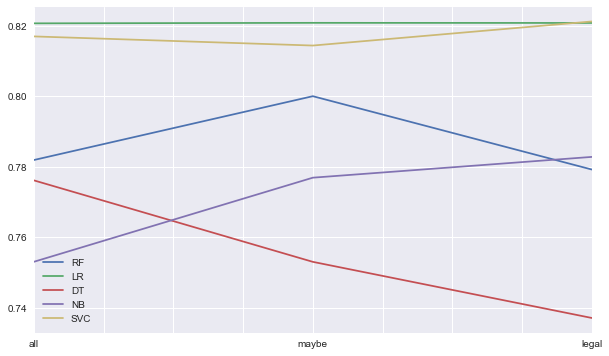

In [14]:
plt.rcParams['figure.figsize'] = [10, 6]
results.T.plot();

The overall trend is as expected: less features leads to worse results. NB and SVC are exceptions, but this may be randomness due to small data.